In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

In [2]:
df = pd.read_parquet('./data/stage2_data.parquet')
train = df.copy()
# train = train.reset_index()

In [3]:
to_remove = train[train['PARTS_NO1'].isna()].index
train = train.drop(to_remove).reset_index()
to_remove = train.groupby('PARTS_NO1').filter(lambda x: len(x) <= 10000).index
train = train.drop(to_remove).reset_index()

In [4]:
# del train['KEY_PARTS1']
# del train['KEY_PARTS2']
# del train['KEY_PARTS3']
# del train['KEY_PARTS4']
# del train['KEY_PARTS5']
# # del train['PARTS_NO1']
# del train['PARTS_NO2']
# del train['PARTS_NO3']
# del train['PARTS_NO4']
# del train['PARTS_NO5']
del train['ENGINEER_REPAIR']
del train['level_0']
del train['index']
# del train['']

In [5]:
train = train.sample(frac=0.5).reset_index()
del train['index']

In [6]:
train.columns

Index(['MONTH', 'RECLAIM_PERIOD', 'SUBSIDIARY_NAME', 'CAPTIVE_CHANNEL_FLAG',
       'COMPANY_CODE', 'DIVISION_NAME', 'MODEL_CODE', 'RECEIPT_SYMPTOM',
       'CENTER_CODE', 'PREV_CENTER_CODE', 'PRODUCT_NAME', 'RECLAIM',
       'WARRANTY_TYPE', 'PREV_WARRANTY_TYPE', 'SVC_TYPE', 'PREV_SVC_TYPE',
       'ENGINEER_CODE', 'PREV_ENGINEER_CODE', 'PREV_ENGINEER_SYMPTOM',
       'MULTICLAIM', 'PREV_RECEIPT_SYMPTOM', 'PARTS_NO1'],
      dtype='object')

In [7]:
train.shape

(1992664, 22)

In [8]:
train['PARTS_NO1'].nunique()

69

In [9]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.7, .2, .1], size=(train.shape[0],))

train_indices = train[train["Set"]=="train"].index
valid_indices = train[train["Set"]=="valid"].index
test_indices = train[train["Set"]=="test"].index

In [11]:
train.columns[-2]

'PARTS_NO1'

In [12]:
train_indices

Index([      0,       2,       3,       4,       5,       6,       9,      10,
            14,      15,
       ...
       1992643, 1992646, 1992647, 1992652, 1992653, 1992654, 1992656, 1992659,
       1992660, 1992661],
      dtype='int64', length=1395739)

In [13]:
target = train.columns[-2]
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    print(types[col])
    if types[col] == 'object':
        train[col] = train[col].astype(str)
        print(col, train[col].nunique())
        train[col] = train[col].fillna("VV_likely")
        l_enc = LabelEncoder()
        # train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

object
MONTH 12
float64
object
SUBSIDIARY_NAME 2
object
CAPTIVE_CHANNEL_FLAG 2
object
COMPANY_CODE 4
object
DIVISION_NAME 18
object
MODEL_CODE 8368
object
RECEIPT_SYMPTOM 167
object
CENTER_CODE 2130
object
PREV_CENTER_CODE 1585
object
PRODUCT_NAME 50
int64
object
WARRANTY_TYPE 8
object
PREV_WARRANTY_TYPE 8
object
SVC_TYPE 8
object
PREV_SVC_TYPE 8
object
ENGINEER_CODE 20659
object
PREV_ENGINEER_CODE 13180
object
PREV_ENGINEER_SYMPTOM 122
int64
object
PREV_RECEIPT_SYMPTOM 132
object
PARTS_NO1 69
object
Set 3


In [14]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [15]:
clf = TabNetClassifier(n_d=16, n_a=16, n_steps=5, gamma=1.5,
                       n_independent=4, n_shared=4,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

/home/js/.conda/envs/LG/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [16]:
# from pytorch_tabnet.augmentations import ClassificationSMOTE
max_epochs = 1000
# aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=100,
    batch_size=2048, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False,
    # augmentations=aug
)

epoch 0  | loss: 2.36528 | train_accuracy: 0.61293 | valid_accuracy: 0.61087 |  0:01:50s
epoch 1  | loss: 1.38842 | train_accuracy: 0.66073 | valid_accuracy: 0.65519 |  0:03:48s
epoch 2  | loss: 1.26321 | train_accuracy: 0.67081 | valid_accuracy: 0.66165 |  0:05:39s
epoch 3  | loss: 1.18905 | train_accuracy: 0.68214 | valid_accuracy: 0.67057 |  0:07:30s
epoch 4  | loss: 1.13428 | train_accuracy: 0.68239 | valid_accuracy: 0.66791 |  0:09:22s
epoch 5  | loss: 1.08708 | train_accuracy: 0.70148 | valid_accuracy: 0.68315 |  0:11:14s
epoch 6  | loss: 1.05515 | train_accuracy: 0.69915 | valid_accuracy: 0.67938 |  0:13:09s
epoch 7  | loss: 1.03062 | train_accuracy: 0.70706 | valid_accuracy: 0.68453 |  0:15:05s
epoch 8  | loss: 1.00923 | train_accuracy: 0.71018 | valid_accuracy: 0.68538 |  0:17:04s
epoch 9  | loss: 0.99376 | train_accuracy: 0.70926 | valid_accuracy: 0.68347 |  0:19:02s
epoch 10 | loss: 0.97959 | train_accuracy: 0.70697 | valid_accuracy: 0.67954 |  0:21:01s
epoch 11 | loss: 0.96

/home/js/.conda/envs/LG/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [17]:
from sklearn.metrics import accuracy_score

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_acc}")

BEST VALID SCORE : 0.6896588074071471
FINAL TEST SCORE : 0.6880941465700079


In [25]:
from sklearn.metrics import f1_score

# Macro F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

Macro F1 Score: 0.4875382589122166


In [27]:
# Get the top 5 predictions for each instance
top_5_preds = np.argsort(preds, axis=1)[:, -5:]

# Check if the true label is among the top 5 predictions
hits = np.array([y_test[i] in top_5_preds[i] for i in range(len(y_test))])

# Initialize counts
tp = np.zeros(len(np.unique(y_test)))  # True Positives
fp = np.zeros(len(np.unique(y_test)))  # False Positives
fn = np.zeros(len(np.unique(y_test)))  # False Negatives

# Calculate TP, FP, FN for each class
for i, label in enumerate(y_test):
    if hits[i]:
        tp[label] += 1
    else:
        fn[label] += 1
        for pred in top_5_preds[i]:
            fp[pred] += 1

# Calculate F1 score for each class
precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) != 0)
recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) != 0)
f1_scores = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(precision), where=(precision + recall) != 0)

# Macro F1 score
f1_macro = np.mean(f1_scores)
print("Macro F1 Score considering top 5 predictions:", f1_macro)

Macro F1 Score considering top 5 predictions: 0.7906115447180513


In [18]:
# preds 배열에서 각 예측에 대해 상위 3개 클래스를 추출
top_5_preds = np.argsort(preds, axis=1)[:, -5:]

# 각 예측에 대해 상위 3개 클래스 중 하나라도 y_test와 일치하는지 검사
y_pred_top5_correct = np.array([y_test[i] in top_5_preds[i] for i in range(len(y_test))])

# 정확도 계산
test_acc = np.mean(y_pred_top5_correct)

print("Test Accuracy considering top 5 predictions:", test_acc)

Test Accuracy considering top 5 predictions: 0.9577227089305236


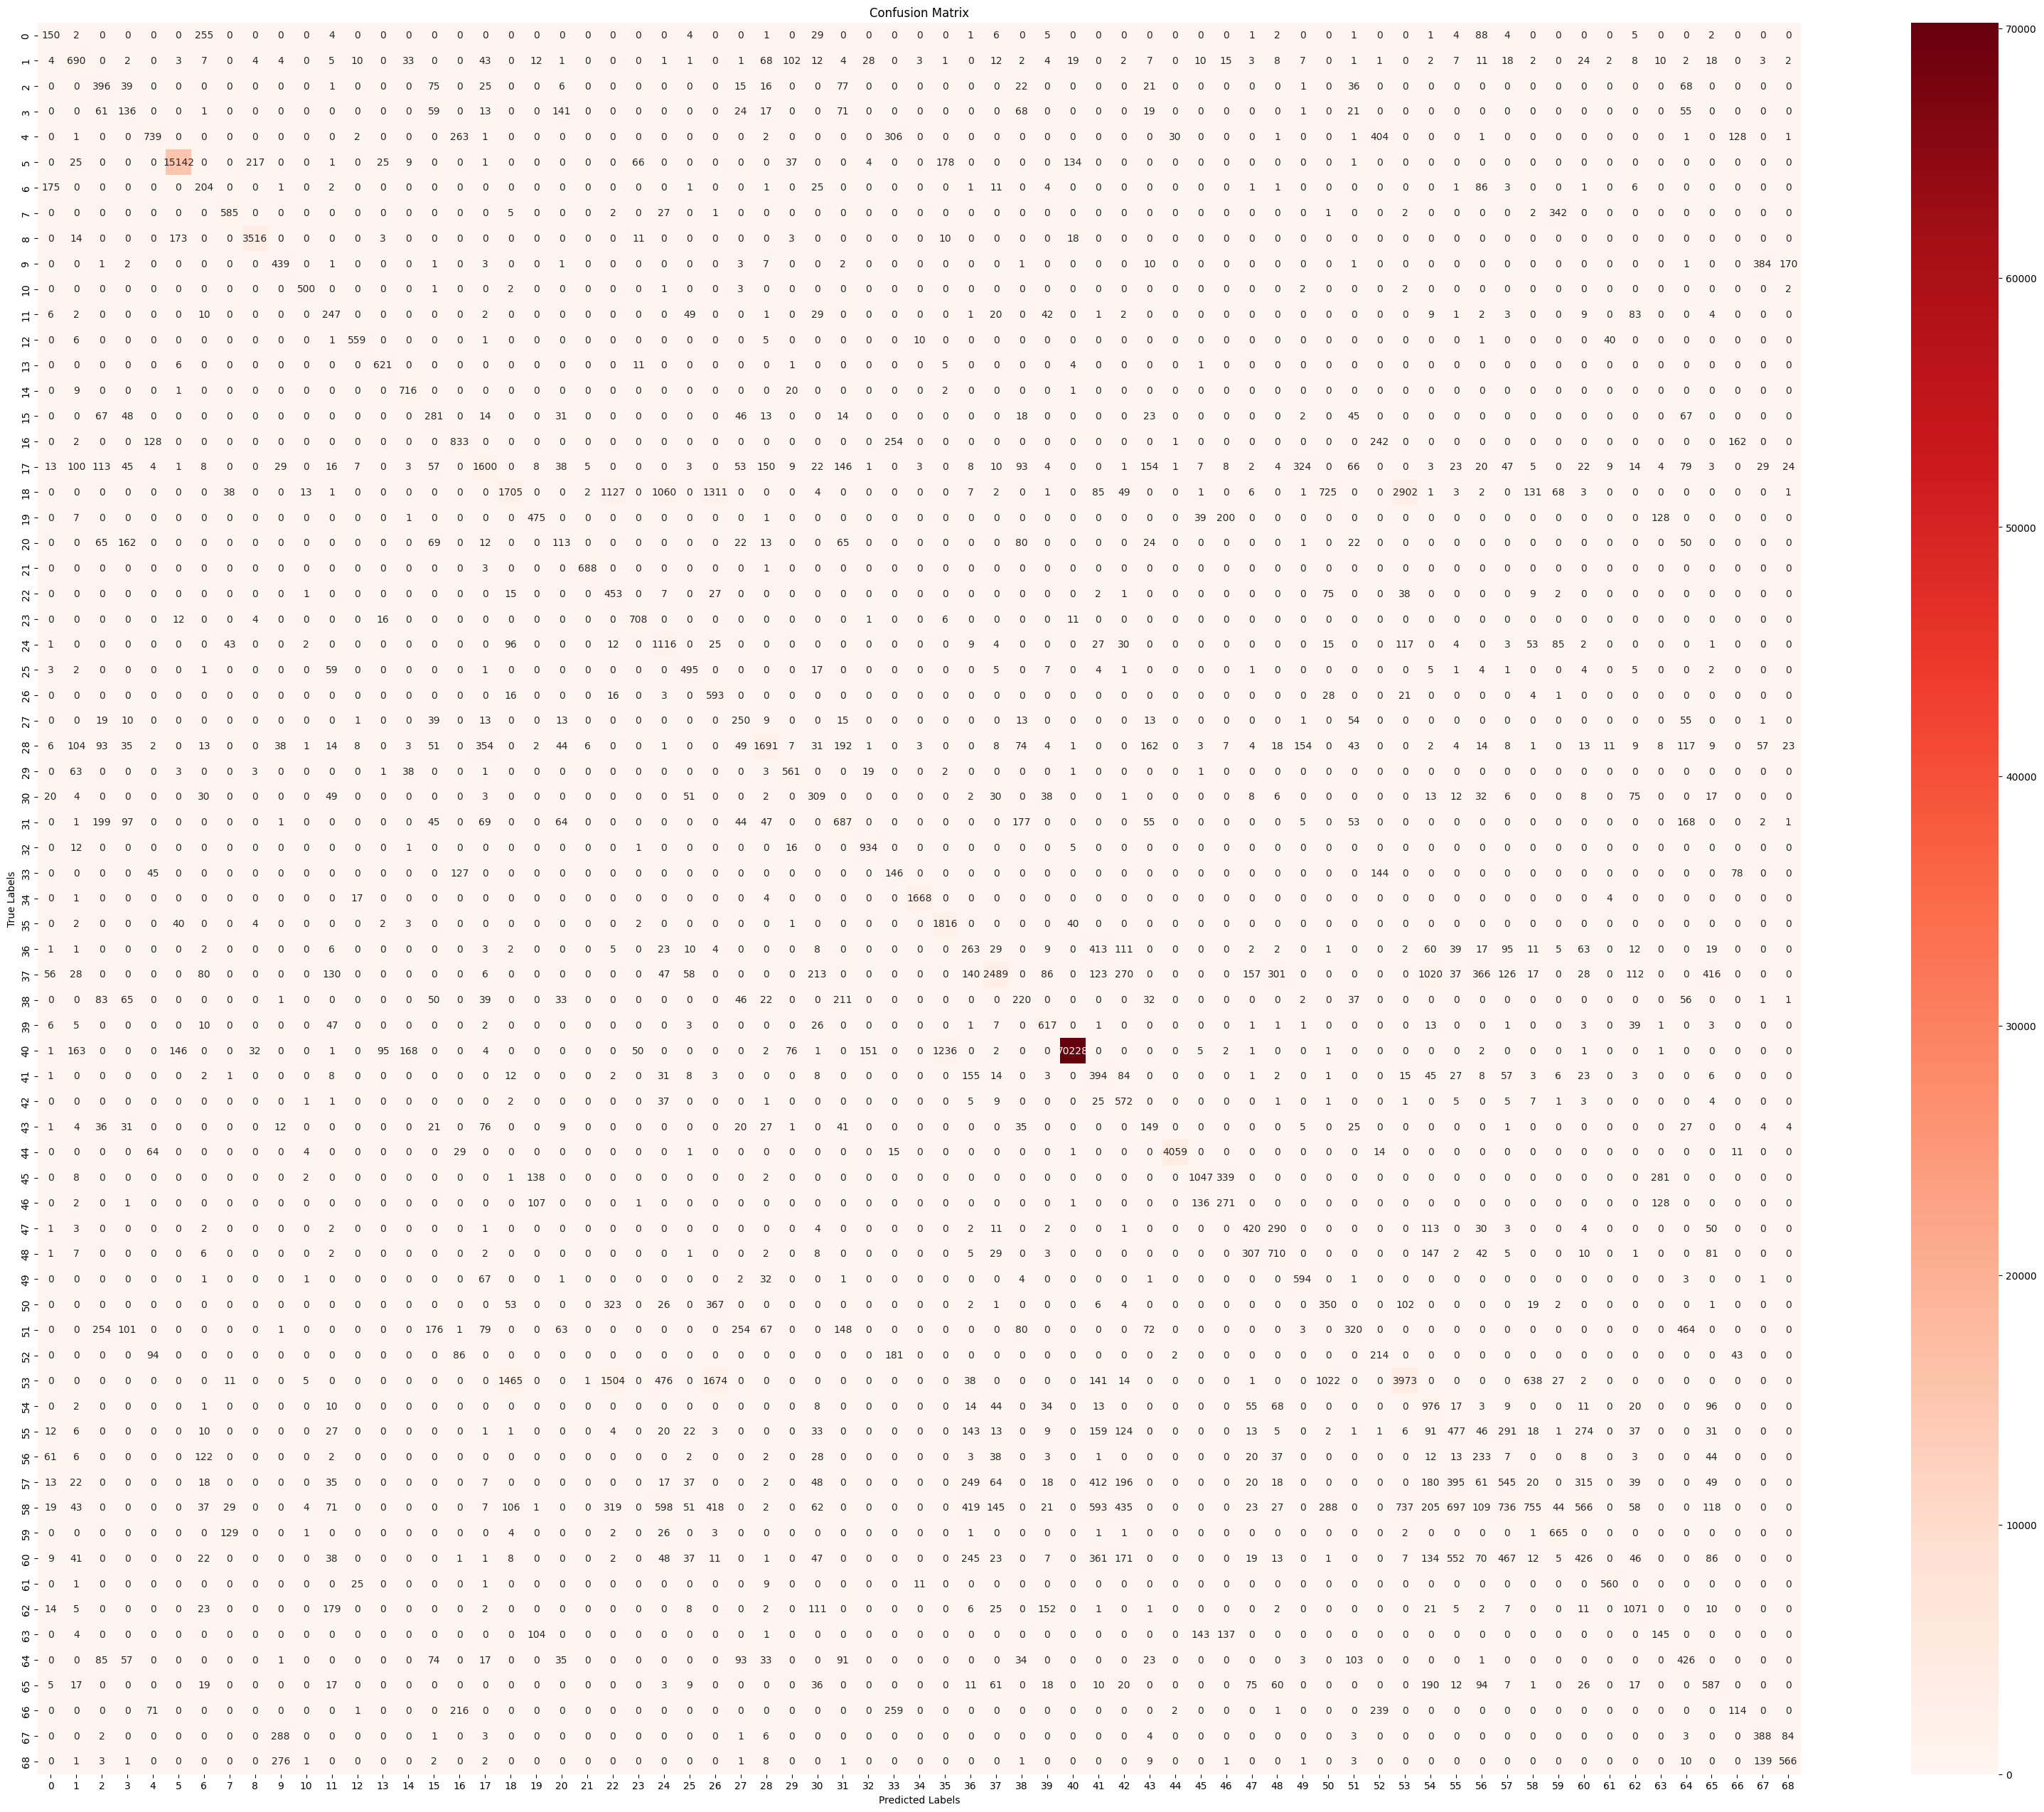

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(40, 32))

# 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

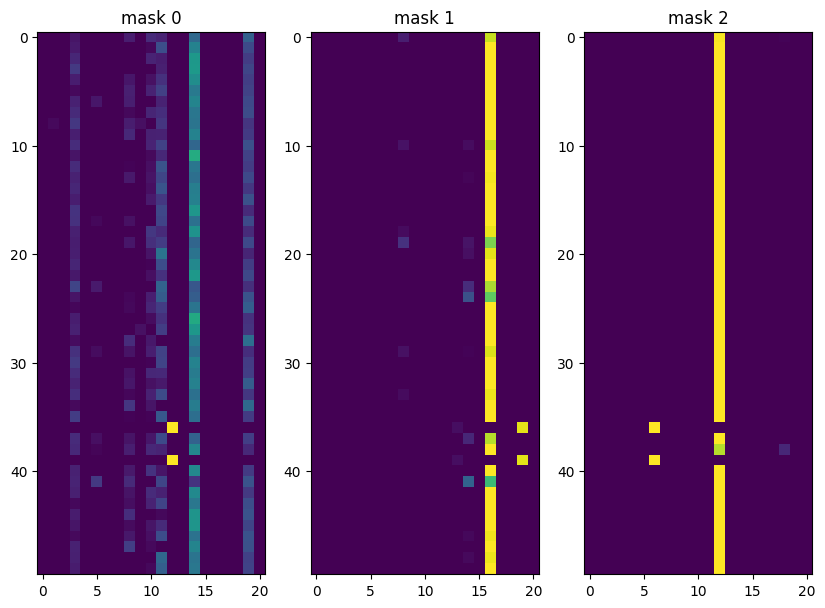

In [20]:
explain_matrix, masks = clf.explain(X_test)
indices = [i for i, x in enumerate(y_pred) if x == 6]
fig, axs = plt.subplots(1, 3, figsize=(10,40))
for i in range(3):
    # random_indices = np.random.choice(masks[i].shape[0], 500, replace=False)
    axs[i].imshow(masks[i][indices[:50]])
    axs[i].set_title(f"mask {i}")

In [23]:
train.columns[19]

'MULTICLAIM'

<Axes: >

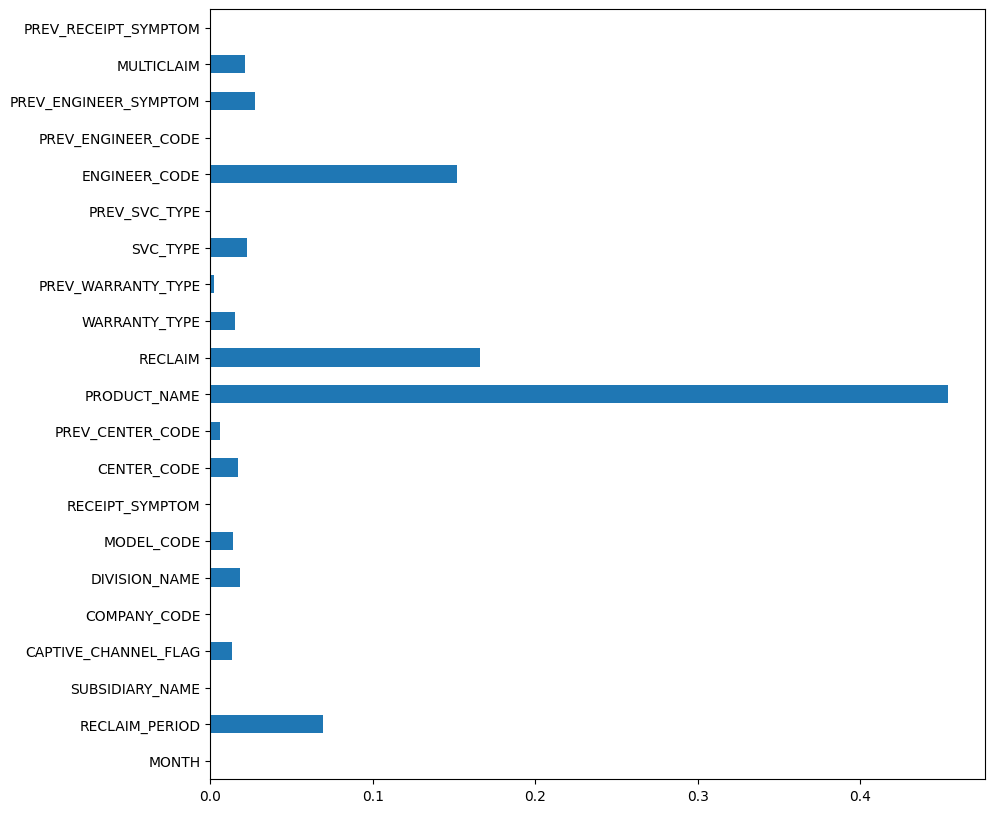

In [24]:
# global
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.plot(kind='barh', figsize=(10,10))